In [1]:
import pandas as pd
from tqdm import tqdm

from data.tokenizer import MyTokenizer

In [2]:
df = pd.read_parquet(
    "/media/luis/BIGGER/datasets/nlp_datasets/metadata/all_metadata_nodup_lang.pq"
)
df = df[df.duplicado_80 == 0].reset_index(drop=True)
df = df[df.lang.isin(["pt", "en", "fr", "it", "es"])].reset_index(drop=True)
df

,txt_len,limpeza_cc,partition_ref,partition_index,base,lang,duplicado_80,duplicado_90,duplicado_95,duplicado_98,tipo
0,467526,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,0,livros,pt,0,0,0,0,pdf
1,52364,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,1,livros,pt,0,0,0,0,pdf
2,389677,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,2,livros,pt,0,0,0,0,pdf
3,913546,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,3,livros,pt,0,0,0,0,pdf
4,564605,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,4,livros,pt,0,0,0,0,pdf
...,...,...,...,...,...,...,...,...,...,...,...
54474988,221909,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,995,pdfs_dominio_publico,pt,0,0,0,0,pdf
54474989,506,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,996,pdfs_dominio_publico,pt,0,0,0,0,pdf
54474990,133266,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,997,pdfs_dominio_publico,en,0,0,0,0,pdf
54474991,1344,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,998,pdfs_dominio_publico,pt,0,0,0,0,pdf


In [3]:
import numpy as np

amostra = []

for base in tqdm(df.base.unique()):
    df_base = df[df.base == base].reset_index(drop=True)
    particoes = list(df_base.partition_ref.unique())
    ps = np.random.choice(particoes, min(len(particoes), 10))
    for p in ps:
        filtered = df_base[df_base.partition_ref == p]
        amostra.append(filtered.sample(min(100, len(filtered))))

amostra = pd.concat(amostra).reset_index(drop=True)
amostra = amostra.drop_duplicates().reset_index(drop=True)
df = None
amostra.base.value_counts()

100%|██████████| 22/22 [01:02<00:00,  2.82s/it]


base
pdfs_dominio_publico                 1000
the_stack_v1_powershell              1000
commom_crawl                         1000
cc100                                1000
wikipedia_en                         1000
sentencas                            1000
blogset_br                           1000
the_stack_v1_shell                   1000
the_stack_v1_python                  1000
dkyoon_slimpajama_6b                 1000
itd_stj                              1000
the_stack_v1_markdown                1000
the_stack_v1_html                    1000
ajibawa_2023_Code_290k_ShareGPT       999
wikipedia_pt                          998
open_orca_slimorca_dedup              997
cshorten_ml_arxiv_papers              996
alpaca                                300
pdfs_tjsp                             207
vikp_textbook_quality_programming     200
the_stack_v1_sql                      200
livros                                 89
Name: count, dtype: int64

In [4]:
from pathlib import Path
from tqdm import tqdm

tokenizers = [
    "/home/luis/projetos/luis_transformers/artifacts/tokenizer_2024_32k",
    "/home/luis/projetos/luis_transformers/artifacts/tokenizer_2024_50k",
    "/home/luis/projetos/luis_transformers/artifacts/tokenizer_2024_60k",
    "/home/luis/projetos/luis_transformers/artifacts/tokenizer_2024_80k",
    "/home/luis/projetos/luis_transformers/artifacts/tokenizer_2024_90k",
    "/home/luis/projetos/luis_transformers/artifacts/tokenizer_2024_100k",
    "/home/luis/projetos/luis_transformers/artifacts/tokenizer_2024_120k",
    "/home/luis/projetos/luis_transformers/artifacts/tokenizer_2024_150k",
]

num_tokenizers = len(tokenizers)
tokenizers = {Path(t).stem: MyTokenizer(tokenizer_path=t) for t in tokenizers}

tokens_tokenizers = {t:[] for t in tokenizers.keys()}

amosta = amostra.sort_values("partition_ref").reset_index(drop=True)
particao_atual = None
nome_particao_atual = None
textos = []
for _, row in tqdm(amostra.iterrows(), total=len(amostra)):
    particao = row.partition_ref
    linha_particao = row.partition_index

    if particao_atual is None or nome_particao_atual != particao:
        # precisa recarregar a particao
        particao_atual = pd.read_parquet(particao)
        nome_particao_atual = particao

    texto = particao_atual.loc[linha_particao, "text"]
    if len(texto) > 40_000:
        texto = texto[:40_000]
    textos.append(texto)

for tokenizer_name, tokenizer in tokenizers.items():
    for texto in tqdm(textos):
        tokens = tokenizer.tokenize_text(texto)
        tokens_tokenizers[tokenizer_name].append(len(tokens))


100%|██████████| 17986/17986 [01:08<00:00, 262.76it/s]


In [5]:
import re
tamanhos = []
contagem = 0
for t in textos:
    palavras = re.sub(r"\n[\n]+?", " ", t).split(" ")
    tamanhos += [len(p) for p in palavras]
    contagem += 1

    if contagem >= 1000:
        break

for p in range(0, 100, 5):
    print(f"{p} - {np.percentile(tamanhos, p)}")

0 - 0.0
5 - 1.0
10 - 1.0
15 - 2.0
20 - 2.0
25 - 2.0
30 - 2.0
35 - 3.0
40 - 3.0
45 - 4.0
50 - 5.0
55 - 5.0
60 - 6.0
65 - 6.0
70 - 7.0
75 - 8.0
80 - 8.0
85 - 9.0
90 - 11.0
95 - 12.0


In [31]:
print(textos[80])



_CADERNOS 
_DO IEB 
_10
Um olhar sobre a literatura_ 
comparada no brasil_ 
Sandra Nitrini 

DOI: 10.11606/9788586748141 
SANDRA NITRINI 
UM OLHAR SOBRE A LITERATURA 
COMPARADA NO BRASIL
1 a edição 
São Paulo 
Instituto de Estudos Brasileiros – IEB/USP
Associação Brasileira de Literatura Comparada – Abralic 2018

UNIVERSIDADE DE SÃO PAULO 
Prof. Dr. Vahan Agopyan 
Prof. Dr. Antonio Carlos Hernandes
reitor 
vice-reitor
_ 
_ 
_
Instituto de estudos brasileiros 
Prof.ª Dr.ª Sandra Margarida Nitrini 
Prof. Dr. Paulo Teixeira Iumatti
diretora 
vice-diretor
cadernos do ieb 
Um olhar sobre a literatura comparada no Brasil 
título 
autora 
Marcos Antonio de Moraes 
editor 
Pedro B. de Meneses Bolle 
Assistente editorial 
Eduardo Junqueira e Karine Tressler 
projeto gráfico 
Divisão Científico-Cultural 

chefe técnico 
difusão cultural 
Flavio Alves Machado 
diagramação 
Cleusa Conte Machado 
preparação e revisão de textos 
capa 

_DO IEB

Copyright © 2018 by Instituto de Estudos Brasileiro

In [6]:
for tokenizer_name in tokens_tokenizers.keys():
    amostra[tokenizer_name] = tokens_tokenizers[tokenizer_name]

amostra

,txt_len,limpeza_cc,partition_ref,partition_index,base,lang,duplicado_80,duplicado_90,duplicado_95,duplicado_98,tipo,tokenizer_2024_32k,tokenizer_2024_50k,tokenizer_2024_60k,tokenizer_2024_80k,tokenizer_2024_90k,tokenizer_2024_100k,tokenizer_2024_120k,tokenizer_2024_150k
0,283765,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,8,livros,pt,0,0,0,0,pdf,12113,11511,11329,11083,10993,10911,10758,10621
1,1196170,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,1,livros,pt,0,0,0,0,pdf,12416,11836,11616,11270,11143,11075,10927,10762
2,500442,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,7,livros,pt,0,0,0,0,pdf,12883,12317,12110,11848,11734,11639,11500,11325
3,47881,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,6,livros,pt,0,0,0,0,pdf,11072,10642,10458,10191,10099,10022,9902,9744
4,387619,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,2,livros,pt,0,0,0,0,pdf,12077,11444,11196,10929,10813,10699,10535,10325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17981,470149,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,701,pdfs_dominio_publico,en,0,0,0,0,pdf,12017,11558,11395,11153,11080,10983,10877,10772
17982,197914,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,939,pdfs_dominio_publico,pt,0,0,0,0,pdf,11985,11560,11407,11194,11122,11041,10933,10823
17983,399704,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,880,pdfs_dominio_publico,pt,0,0,0,0,pdf,24238,23898,23769,23566,23475,23428,23366,23268
17984,196697,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,812,pdfs_dominio_publico,pt,0,0,0,0,pdf,16657,16300,16188,16076,16041,15986,15899,15806


In [7]:
primeiro = None
for tokenizer_name in tokens_tokenizers.keys():
    if primeiro is None:
        primeiro = amostra.groupby(["lang", "base"])[tokenizer_name].describe()
    print(tokenizer_name)
    print(amostra.groupby(["lang", "base"])[tokenizer_name].describe() / primeiro)

tokenizer_2024_32k
                                        count  mean  std  min  25%  50%  75%  \
lang base                                                                      
en   ajibawa_2023_Code_290k_ShareGPT      1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     commom_crawl                         1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     cshorten_ml_arxiv_papers             1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     dkyoon_slimpajama_6b                 1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     open_orca_slimorca_dedup             1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     pdfs_dominio_publico                 1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     the_stack_v1_html                    1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     the_stack_v1_markdown                1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     the_stack_v1_powershell              1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     the_stack_v1_python                  1.0   1.0  1.0  1.0  1.0  1.0  1.0   
     the_stack_v1_she

In [8]:
primeiro = None
for tokenizer_name in tokens_tokenizers.keys():
    if primeiro is None:
        primeiro = amostra.groupby(["lang"])[tokenizer_name].describe()
    print(tokenizer_name)
    print(amostra.groupby(["lang"])[tokenizer_name].describe() / primeiro)

tokenizer_2024_32k
      count  mean  std  min  25%  50%  75%  max
lang                                           
en      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
es      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
fr      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
it      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
pt      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
tokenizer_2024_50k
      count      mean       std       min       25%       50%       75%  \
lang                                                                      
en      1.0  0.968008  0.975370  0.941176  0.954717  0.963415  0.959149   
es      1.0  0.962097  0.962268  0.985714  0.949676  0.983847  0.975756   
fr      1.0  0.965473  0.978416  0.936170  0.980186  0.957246  0.957233   
it      1.0  0.958781  0.961414  0.979239  0.944954  0.951243  0.949498   
pt      1.0  0.962904  0.966943  1.000000  0.959559  0.959528  0.957624   

           max  
lang            
en    0.999772  
es    0.965667  
fr    0.997906  
it    0.961166 

In [9]:
import numpy as np
dados = {
    "base": [],
    "tokenizer": [],
    "lang": [],
    "p": [],
    "value": []
}

dados_lang = {
    "lang": [],
    "p": [],
    "value": [],
    "tokenizer": []
}
for base in amostra.base.unique():
    local = amostra[amostra.base == base].reset_index(drop=True)

    for tokenizer_name in tokens_tokenizers.keys():
        tipo_tokenizer = tokenizer_name.split("_")[-1]
        # print(tokenizer_name)
        # percentis = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
        # for p in percentis:
        #     valor = np.percentile(local[tokenizer_name].tolist(), int(p*100))
        valor = np.sum(local[tokenizer_name].tolist())
        p = 1
        dados["base"].append(base)
        dados["tokenizer"].append(tokenizer_name)
        dados["lang"].append(local.loc[0, "lang"])
        dados["value"].append(valor)
        dados["p"].append(int(100*p))

        # media = np.mean(tokens_tokenizers[tokenizer_name])
        # print(media)
        # minimo = np.min(tokens_tokenizers[tokenizer_name])
        # print(minimo)
        # maximo = np.max(tokens_tokenizers[tokenizer_name])
        # print(maximo)
        # print("\n")
            
for lang in amostra.lang.unique():
    local = amostra[amostra.lang == lang].reset_index(drop=True)
    for tokenizer_name in tokens_tokenizers.keys():
        tipo_tokenizer = tokenizer_name.split("_")[-1]
        # percentis = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
        # for p in percentis:
        #     valor = np.percentile(local[tokenizer_name].tolist(), int(p*100))
        
        valor = np.sum(local[tokenizer_name].tolist())
        p = 1
        dados_lang["tokenizer"].append(tokenizer_name)
        dados_lang["lang"].append(local.loc[0, "lang"])
        dados_lang["value"].append(valor)
        dados_lang["p"].append(int(100*p))

In [10]:
for k in dados.keys():
    print(len(dados[k]))

176
176
176
176
176


In [11]:
dados_df_base = pd.DataFrame(dados)
dados_df_lang = pd.DataFrame(dados_lang)
dados_df_lang

,lang,p,value,tokenizer
0,pt,100,20195900,tokenizer_2024_32k
1,pt,100,19446716,tokenizer_2024_50k
2,pt,100,19189661,tokenizer_2024_60k
3,pt,100,18834185,tokenizer_2024_80k
4,pt,100,18692352,tokenizer_2024_90k
5,pt,100,18580927,tokenizer_2024_100k
6,pt,100,18404002,tokenizer_2024_120k
7,pt,100,18211199,tokenizer_2024_150k
8,en,100,18781149,tokenizer_2024_32k
9,en,100,18180305,tokenizer_2024_50k


In [12]:
# normaliza pelo maior
normalizada_base = []
for base in dados_df_base.base.unique():
    for p in dados_df_base.p.unique():
        local = dados_df_base[(dados_df_base.base == base) & (dados_df_base.p == p)]
        local.value  = local.value / local.value.max()
        normalizada_base.append(local)
normalizada_base = pd.concat(normalizada_base).reset_index(drop=True)

normalizada_lang = []
for lang in dados_df_lang.lang.unique():
    for p in dados_df_lang.p.unique():
        local = dados_df_lang[(dados_df_lang.lang == lang) & (dados_df_lang.p == p)]
        local.value  = local.value / local.value.max()
        normalizada_lang.append(local)
normalizada_lang = pd.concat(normalizada_lang).reset_index(drop=True)
normalizada_lang

/tmp/ipykernel_472084/1386765431.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local.value  = local.value / local.value.max()
/tmp/ipykernel_472084/1386765431.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local.value  = local.value / local.value.max()


,lang,p,value,tokenizer
0,pt,100,1.000000,tokenizer_2024_32k
1,pt,100,0.962904,tokenizer_2024_50k
2,pt,100,0.950176,tokenizer_2024_60k
3,pt,100,0.932575,tokenizer_2024_80k
4,pt,100,0.925552,tokenizer_2024_90k
5,pt,100,0.920035,tokenizer_2024_100k
6,pt,100,0.911274,tokenizer_2024_120k
7,pt,100,0.901728,tokenizer_2024_150k
8,en,100,1.000000,tokenizer_2024_32k
9,en,100,0.968008,tokenizer_2024_50k


In [13]:
normalizada_base["tokenizer_size"] = normalizada_base.tokenizer.apply(lambda x: int(x.split("_")[-1].replace("k", "")))
normalizada_lang["tokenizer_size"] = normalizada_lang.tokenizer.apply(lambda x: int(x.split("_")[-1].replace("k", "")))

In [14]:
pt_base = pd.pivot_table(data=normalizada_base[normalizada_base.p.isin([100, 20, 50, 90, 99])], values="value", index=["base", "tokenizer_size", "lang"], columns="p")
pt_base

p                                                         100
base                            tokenizer_size lang          
ajibawa_2023_Code_290k_ShareGPT 32             en    1.000000
                                50             en    0.970518
                                60             en    0.961211
                                80             en    0.947480
                                90             en    0.943068
...                                                       ...
wikipedia_pt                    80             pt    0.915138
                                90             pt    0.906992
                                100            pt    0.900062
                                120            pt    0.888601
                                150            pt    0.876629

[176 rows x 1 columns]

In [15]:
pt_lang = pd.pivot_table(data=normalizada_lang[normalizada_lang.p.isin([20, 50, 90, 99, 100])], values="value", index=["lang", "tokenizer_size"], columns="p")
pt_lang

p                         100
lang tokenizer_size          
en   32              1.000000
     50              0.968008
     60              0.956906
     80              0.940812
     90              0.935123
     100             0.930477
     120             0.922973
     150             0.914799
es   32              1.000000
     50              0.962097
     60              0.947293
     80              0.925953
     90              0.916823
     100             0.910446
     120             0.898614
     150             0.883392
fr   32              1.000000
     50              0.965473
     60              0.950312
     80              0.930445
     90              0.922315
     100             0.915686
     120             0.904503
     150             0.891104
it   32              1.000000
     50              0.958781
     60              0.938639
     80              0.911237
     90              0.898686
     100             0.890132
     120             0.876229
     150             0.862629
pt   32              1.000000
     50              0.962904
     60              0.950176
     80              0.932575
     90              0.925552
     100             0.920035
     120             0.911274
     150             0.901728

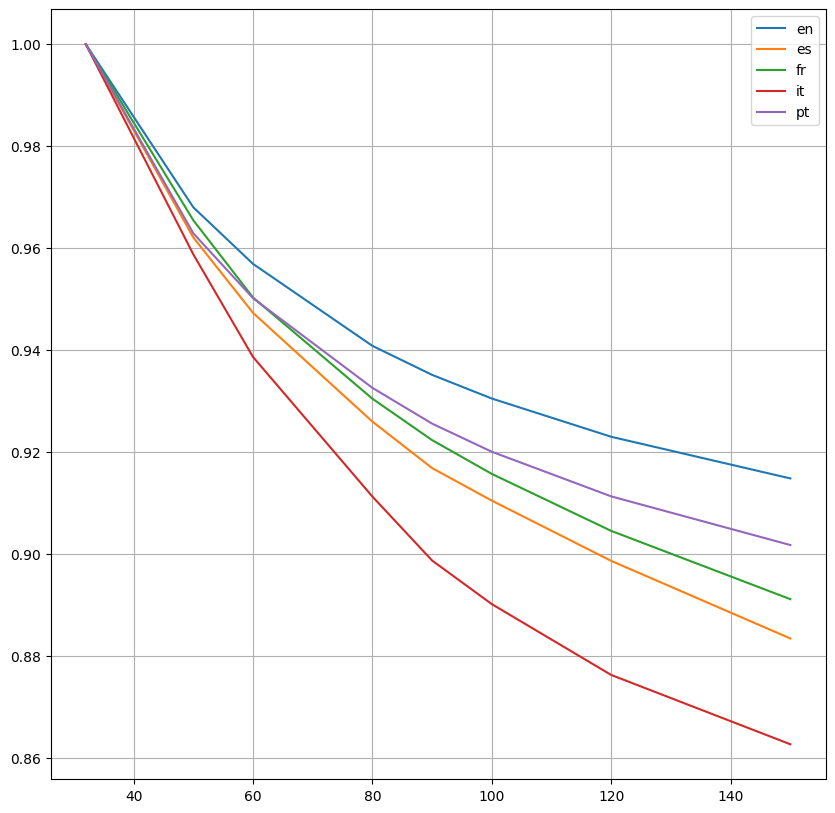

In [16]:
num_tokenizers = len(tokenizers)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

for i in range(0, len(pt_lang), num_tokenizers):
    indexes = [ind[1] for ind in pt_lang.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_lang.iloc[i:i + num_tokenizers].index]
    ax.plot(indexes, pt_lang.iloc[i:i + num_tokenizers][100].values, label=bases[0])
ax.grid()
ax.legend()

In [17]:
num_tokenizers = len(tokenizers)

import plotly.graph_objects as go

fig = go.Figure()

for i in range(0, len(pt_lang), num_tokenizers):
    indexes = [ind[1] for ind in pt_lang.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_lang.iloc[i:i + num_tokenizers].index]
    fig.add_trace(
        go.Scatter(
            x = indexes,
            y = pt_lang.iloc[i:i + num_tokenizers][100].values,
            name = bases[0],
        )
    )
fig.update_layout(
    height=1000
)
fig.show()

In [18]:
import plotly.graph_objects as go

cores_langs = {
    "pt": "green",
    "en": "red",
    "it": "blue",
    "fr": "blue",
    "es": "blue"
}

dashes_bases = {
    "the_stack_v1_html": "dot",
    "the_stack_v1_markdown": "dot",
    "the_stack_v1_shell": "dot",
    "the_stack_v1_python": "dot",
    "ajibawa_2023_Code_290k_ShareGPT": "dot",
    "the_stack_v1_powershell": "dot",
    "the_stack_v1_sql": "dot",
    "vikp_textbook_quality_programming": "dot",
    "cc100":"dash",
    "dkyoon_slimpajama_6b":"dash",
    "wikipedia_en":"dash",
    "wikipedia_pt":"dash",
    "commom_crawl":"dash",
    "blogset_br":"dash",
    "cshorten_ml_arxiv_papers":"dash",
    "sentencas": "dashdot",
    "itd_stj": "dashdot",
    "pdfs_tjsp": "dashdot",
    "pdfs_dominio_publico": "dashdot",
    "livros": "dashdot",
    "open_orca_slimorca_dedup": "dot",
    "alpaca": "dot",
}

fig = go.Figure()

for i in range(0, len(pt_base), num_tokenizers):
    indexes = [ind[1] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    langs = [ind[2] for ind in pt_base.iloc[i: i + num_tokenizers].index]
    fig.add_trace(
        go.Scatter(
            x = indexes,
            y = pt_base.iloc[i:i + num_tokenizers][100].values,
            name = bases[0],
            line=dict(color=cores_langs[langs[0]], dash=dashes_bases[bases[0]])
        )
    )
fig.update_layout(
    height=1000
)
fig.show()


/tmp/ipykernel_449922/821748164.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



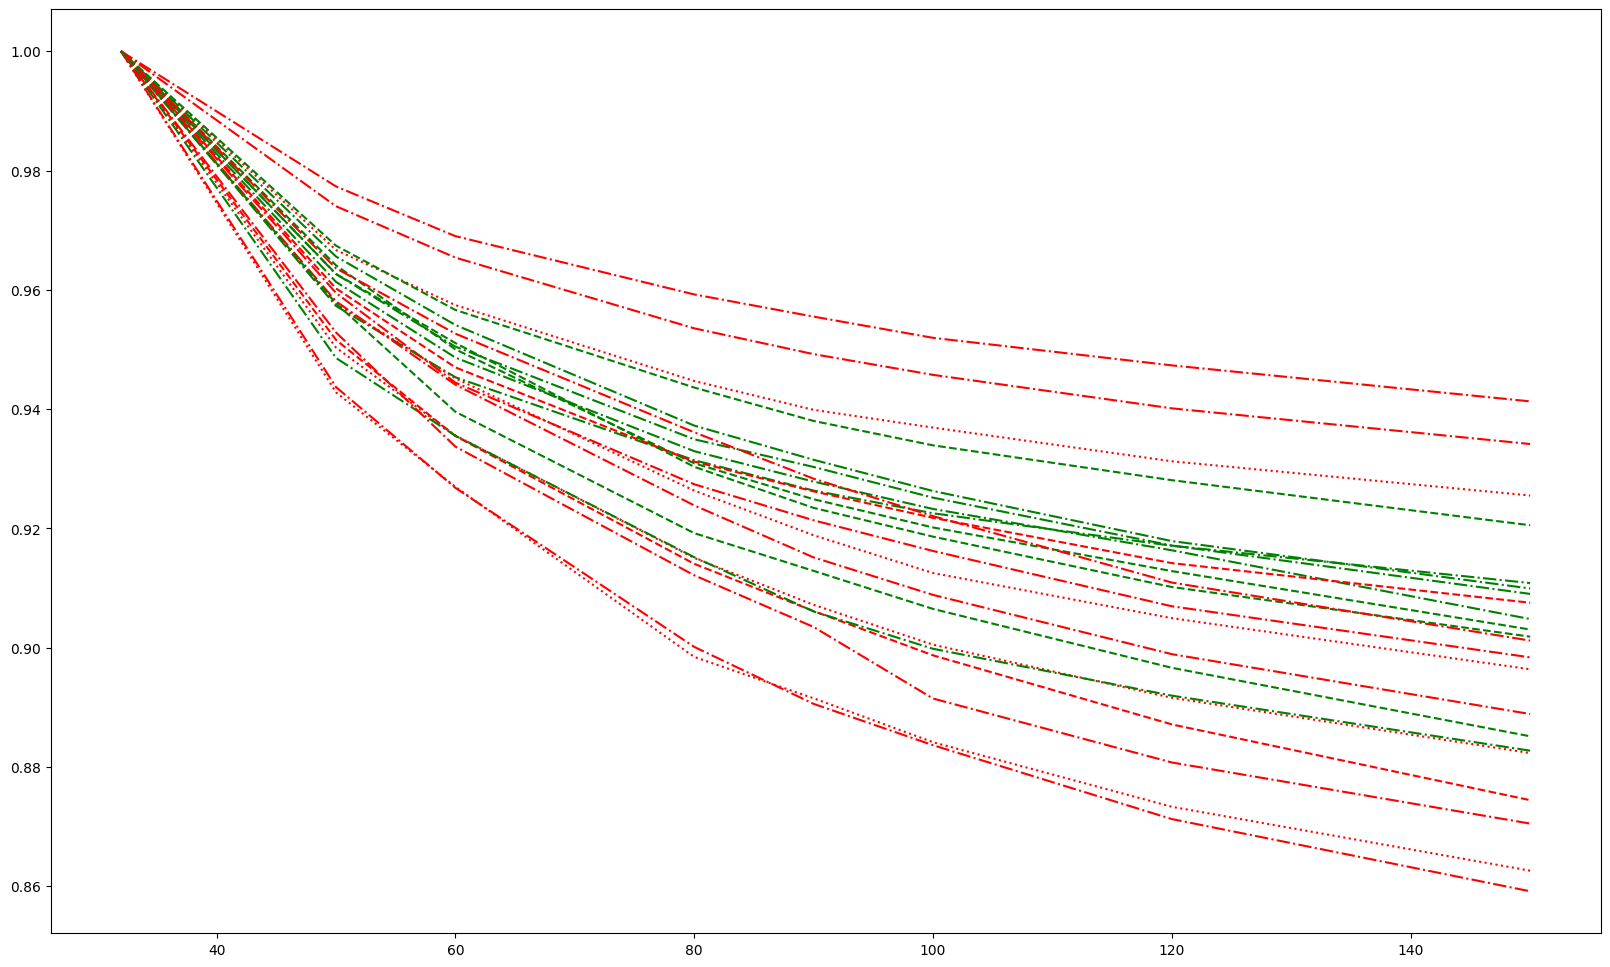

In [18]:
import matplotlib.pyplot as plt
import numpy as np

cores_langs = {
    "pt": "green",
    "en": "red",
    "it": "blue",
    "fr": "black",
    "es": "yellow"
}

fig, ax = plt.subplots()
fig.set_size_inches(20, 12)

for i in range(0, len(pt_base), num_tokenizers):
    indexes = [ind[1] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    langs = [ind[2] for ind in pt_base.iloc[i: i + num_tokenizers].index]
    ax.plot(indexes, pt_base.iloc[i:i + num_tokenizers][100].values, label=bases[0], linestyle=np.random.choice(["-.", "--", "-.", ":"]), color=cores_langs[langs[0]])
ax.grid()
ax.legend()

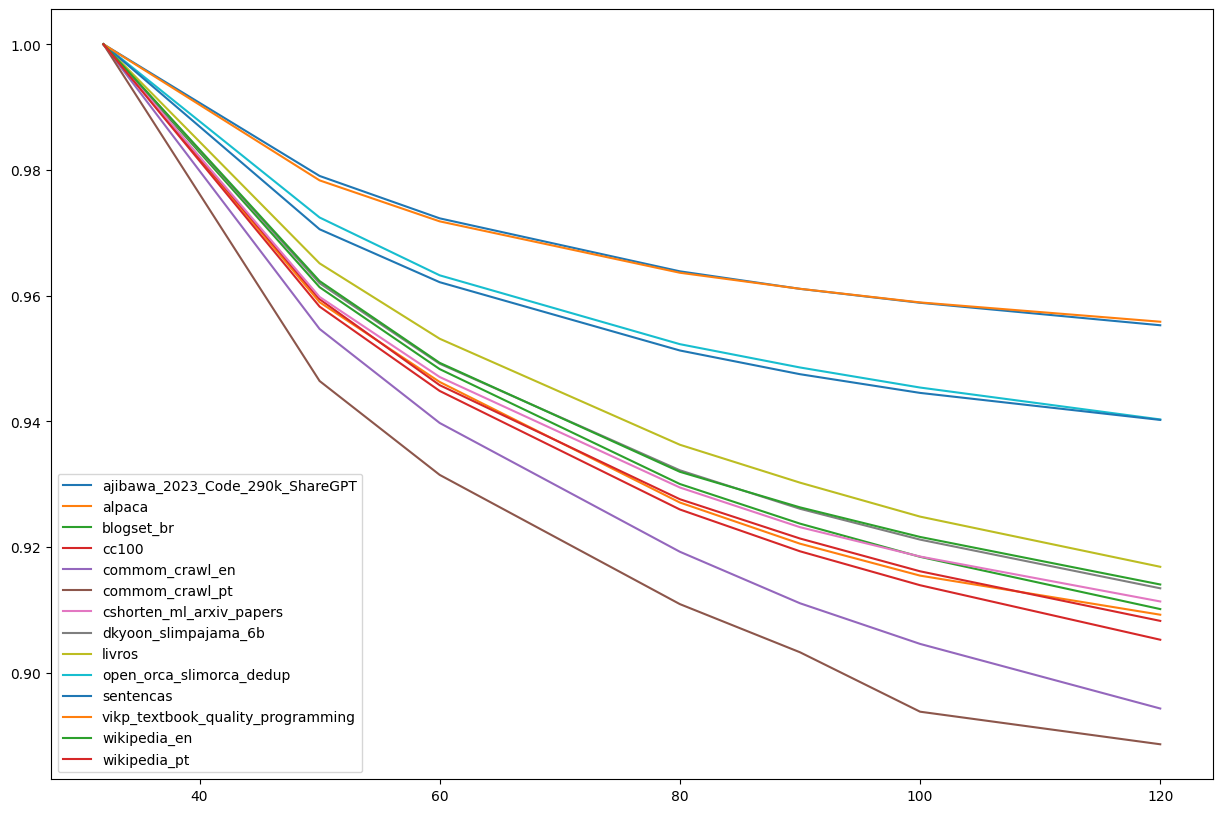

In [199]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

for i in range(0, len(pt_base), num_tokenizers):
    indexes = [ind[1] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    ax.plot(indexes, pt_base.iloc[i:i + num_tokenizers][100].values, label=bases[0])
ax.legend()